In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
from multiprocessing.dummy import Pool
import math

import torch

import numpy as np
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
import random
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter

In [3]:
train_csv = pd.read_csv("data/train_features.csv")
train = train_csv.to_numpy()
train_csv

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [4]:
train.shape

(1875000, 8)

In [5]:
xs_train = np.stack(np.split(train[:, 2:].T, 3125, 1))
xs_train.shape

(3125, 6, 600)

In [6]:
test_csv = pd.read_csv("data/test_features.csv")
test = test_csv.to_numpy()
test_csv

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,3125,0,-0.628100,-0.160155,0.151487,49.665357,88.435961,13.597668
1,3125,1,-0.462548,0.012462,-0.053726,56.953059,96.185341,16.278458
2,3125,2,-0.363481,-0.091789,-0.130004,29.557396,93.836453,13.329043
3,3125,3,-0.351750,-0.239870,-0.193053,23.686172,88.608721,13.449771
4,3125,4,-0.312934,-0.123762,-0.318621,20.410071,85.327707,13.884912
...,...,...,...,...,...,...,...,...
469195,3906,595,0.104191,-0.784979,0.639513,-10.475346,14.095361,-190.358982
469196,3906,596,0.103297,-0.758954,0.615687,-25.360272,-8.523018,-180.393291
469197,3906,597,0.128294,-0.749389,0.586184,-27.917723,-23.186245,-162.624160
469198,3906,598,0.104130,-0.692731,0.573397,-27.847980,-30.407555,-138.761676


In [7]:
xs_test = np.stack(np.split(test[:, 2:].T, 782, 1))

In [8]:
xs_test.shape

(782, 6, 600)

In [9]:
xs = np.concatenate([xs_train, xs_test])

In [10]:
for i in range(2, 8):
    print(
        f"{i}: {train[:, i].mean():.4f}, {train[:, i].std():.4f}, {train[:, i].max():.4f}, {train[:, i].min():.4f}"
    )

2: -0.4490, 0.7173, 8.4268, -8.8384
3: -0.1618, 0.5872, 8.4846, -9.2997
4: 0.0557, 0.4725, 6.4327, -8.3164
5: -1.3080, 60.8323, 1870.2560, -1811.1267
6: -0.4338, 73.2983, 2111.6568, -1594.2556
7: 0.8864, 70.6334, 1255.8492, -1346.1430


In [11]:
xs = torch.tensor(xs, dtype=torch.float32)

In [12]:
xs.shape

torch.Size([3907, 6, 600])

In [13]:
xs_ = (xs.clone() - xs.mean(dim=2, keepdim=True)) / xs.std(dim=2, keepdim=True)

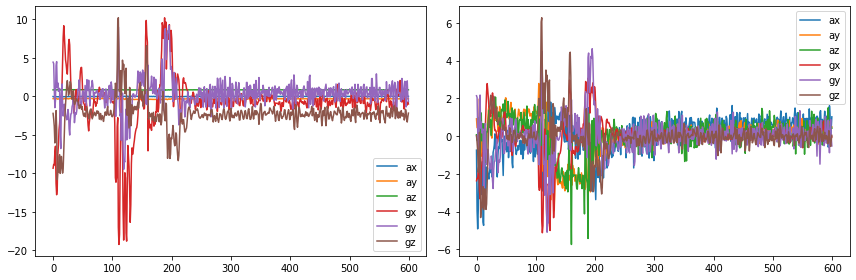

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(xs[13].transpose(0, 1))
plt.legend(["ax", "ay", "az", "gx", "gy", "gz"])
plt.subplot(1, 2, 2)
plt.plot(xs_[13].transpose(0, 1))
plt.legend(["ax", "ay", "az", "gx", "gy", "gz"])
plt.tight_layout()
plt.show()

In [15]:
xs[13, :, 0], xs[13, :, -1]

(tensor([-0.0313, -0.3020,  0.8392, -9.3312,  4.4283, -2.2163]),
 tensor([-0.0032, -0.3160,  0.8428, -0.9979, -0.6906, -2.1819]))

In [16]:
xs_[13, :, 0], xs_[13, :, -1]

(tensor([-0.7461,  0.9144,  0.0712, -2.3703,  2.1381,  0.0195]),
 tensor([ 1.0202,  0.4848,  0.4147, -0.0481, -0.5249,  0.0369]))

# 속도를 역산

In [17]:
vs = [torch.zeros(xs_.shape[:2])]
for i in range(1, 600):
    vs.append(xs_[:, :, i] * 0.02 + vs[i - 1])

In [18]:
vs = torch.stack(vs, dim=2)

In [19]:
vs.shape

torch.Size([3907, 6, 600])

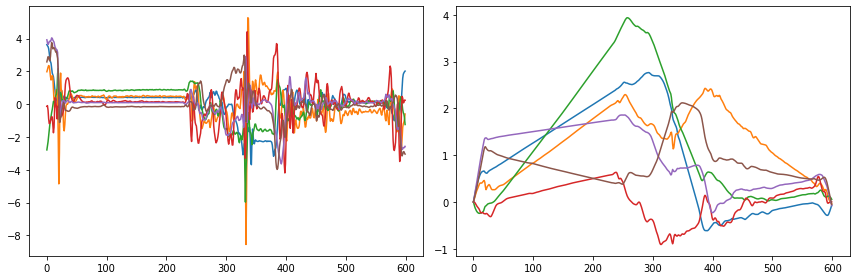

In [20]:
j = 17
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(xs_[j].transpose(0, 1))
plt.subplot(1, 2, 2)
plt.plot(vs[j].transpose(0, 1))
plt.tight_layout()
plt.show()

# 가속도를 미분

In [21]:
ts = [torch.zeros(xs_.shape[:2])]
for i in range(1, 600):
    ts.append((xs_[..., i] - xs_[..., i - 1]) / 0.02)
ts = torch.stack(ts, dim=2)

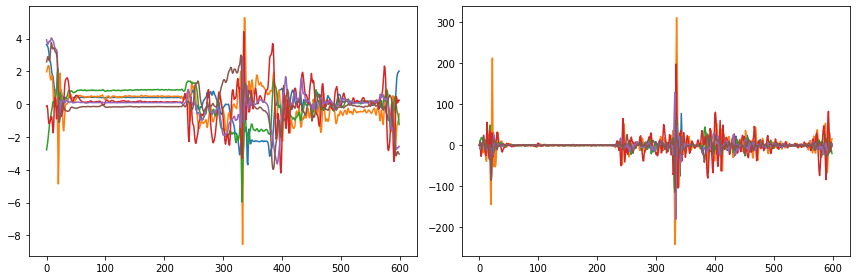

In [22]:
j = 17
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(xs_[j].transpose(0, 1))
plt.subplot(1, 2, 2)
plt.plot(ts[j].transpose(0, 1))
plt.tight_layout()
plt.show()

# 파일로 저장

In [23]:
labels = pd.read_csv("data/train_labels.csv")
labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [24]:
labels = labels["label"].to_numpy()

In [25]:
len(labels)

3125

In [26]:
np.savez_compressed(
    "data/0214.npz",
    X_train=xs_[: len(labels)].numpy(),
    Y_train=labels,
    X_test=xs_[len(labels) :].numpy(),
)